# Hugonnet DEM void imputation (RBF sampler + Bayesian ridge)


This notebook implements the following logic:

- Build/read a library of connected void-pattern masks
- Compute per-glacier predictor stacks (x/y, Cop30 elevation, slope, aspect sin/cos, year)
- Create synthetic voids by placing library patterns onto non-void areas until a target proportion is reached
- Tune hyperparameters (gamma, n_components) with Bayesian optimisation using 5 synthetic realisations
- Fit final per-glacier models using the selected hyperparameters
- Predict full rasters per year and overwrite the original voids

## Imports and configuration

In [1]:
import numpy as np
import pandas as pandas
import xarray
import rioxarray
from scipy import ndimage

import sklearn.pipeline
import sklearn.kernel_approximation
import sklearn.linear_model

import skopt
import skopt.space
import skopt.utils
import skopt.callbacks

from tqdm import tqdm
import os
import glob
import pickle

In [2]:
MAX_POSITION_TRIES_PER_VOID = 100
USE_PRECOMPUTED_VOID_LIBRARY = True
PRECOMPUTED_TARGET_PROPORTION = 0.046904449909350374
SUBSAMPLE_SIZE = 20000

## Paths (edit as needed)


Make sure that Cop30DEM elevation and derivatives are reprojected to the same grid as the Hugonnet et al. data.

In [3]:
COP30_ELEVATION_DIR = "cop30dem/elevation"
HUGONNET_TILES_DIR = "hugonnet_dems/tiles"

COP30_SLOPE_DIR = "cop30dem/slope"
COP30_ASPECT_DIR = "cop30dem/aspect"

OUT_IMPUTING_MODELS_DIR = "outputs/imputing_models"
OUT_HP_TUNING_DIR = "outputs/hp_tuning"
OUT_MODELLED_DIR = "outputs/modelled_by_rbf_br"

os.makedirs(OUT_IMPUTING_MODELS_DIR, exist_ok=True)
os.makedirs(OUT_HP_TUNING_DIR, exist_ok=True)
os.makedirs(OUT_MODELLED_DIR, exist_ok=True)

## Helper functions

In [4]:
def list_glaciers():
    tif_paths = glob.glob(os.path.join(COP30_ELEVATION_DIR, "*.tif"))
    glaciers = sorted([os.path.basename(p)[:-4] for p in tif_paths])
    return glaciers


def load_hugonnet_tile_paths(glacier):
    h_elev_paths = sorted(glob.glob(os.path.join(HUGONNET_TILES_DIR, f"Z_{glacier}_*.tif")))
    h_stddev_paths = sorted(glob.glob(os.path.join(HUGONNET_TILES_DIR, f"ZSTDDEV_{glacier}_*.tif")))
    return h_elev_paths, h_stddev_paths


def compute_original_void_mask(h_elev_paths):
    stack = []
    for elev_path in h_elev_paths:
        elev = rioxarray.open_rasterio(elev_path, masked=True)[0]
        stack.append(elev.data)
    stack = np.stack(stack, axis=0)
    voids = np.isnan(stack).any(axis=0).astype(np.uint8)
    return voids


def extract_connected_void_patterns(void_mask):
    if np.all(void_mask == 0):
        return []

    labelled, _ = ndimage.label(void_mask, structure=[[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    slices = ndimage.find_objects(labelled)

    patterns = []
    for lbl, slc in enumerate(slices, start=1):
        void = (labelled[slc] == lbl).astype(np.uint8)
        patterns.append(void)
    return patterns


def load_cop30_predictors(glacier):
    cop30_elev = rioxarray.open_rasterio(os.path.join(COP30_ELEVATION_DIR, f"{glacier}.tif"), masked=True)[0].rio.interpolate_na()
    cop30_slope = rioxarray.open_rasterio(os.path.join(COP30_SLOPE_DIR, f"{glacier}.tif"), masked=True)[0].rio.interpolate_na()
    cop30_aspect = rioxarray.open_rasterio(os.path.join(COP30_ASPECT_DIR, f"{glacier}.tif"), masked=True)[0].rio.interpolate_na()

    cop30_aspect = cop30_aspect / 180.0 * np.pi
    aspect_sin = np.sin(cop30_aspect.data)
    aspect_cos = np.cos(cop30_aspect.data)

    xv = cop30_elev["x"].values
    yv = cop30_elev["y"].values
    xgrid, ygrid = np.meshgrid(xv, yv)
    x_norm = (xgrid - xv.min()) / (xv.max() - xv.min())
    y_norm = (ygrid - yv.min()) / (yv.max() - yv.min())

    return x_norm, y_norm, cop30_elev.data, cop30_slope.data, aspect_sin, aspect_cos


def build_xyw_triples_for_glacier(glacier, h_elev_paths, h_stddev_paths):
    x_norm, y_norm, cop30_elev, cop30_slope, aspect_sin, aspect_cos = load_cop30_predictors(glacier)

    xyws = []
    for z_path, zstddev_path in zip(h_elev_paths, h_stddev_paths):
        year = float(os.path.basename(z_path)[:-4].split("_")[-1])

        z = rioxarray.open_rasterio(z_path, masked=True)[0]
        zstddev = rioxarray.open_rasterio(zstddev_path, masked=True)[0]

        alpha = (zstddev ** 2).data
        target = (z.data - cop30_elev)

        years = np.full_like(cop30_elev, year, dtype=float)

        predictors = [
            x_norm,
            y_norm,
            cop30_elev,
            cop30_slope,
            aspect_sin,
            aspect_cos,
            years,
        ] # 7 predictors
        predictors = np.stack(predictors, axis=-1)
        xyws.append((predictors, target, alpha))

    return xyws


def compute_predictor_minmax(xyw_triples):
    predictors_mins = np.full(7, np.inf) # 7 predictors hard-coded here
    predictors_maxs = np.full(7, -np.inf)

    for x, _, _ in xyw_triples:
        loc_mins = np.min(x, axis=(0, 1))
        loc_maxs = np.max(x, axis=(0, 1))
        predictors_mins = np.minimum(predictors_mins, loc_mins)
        predictors_maxs = np.maximum(predictors_maxs, loc_maxs)

    return predictors_mins, predictors_maxs


def place_voids(mask, library, target_proportion, rng):
    h, w = mask.shape
    proportion = 0.0

    contaminated_mask = mask.copy()
    added_voids = np.zeros_like(mask)

    while proportion < target_proportion:
        void_idx = rng.choice(len(library))
        void = library[void_idx]
        void = np.rot90(void, k=rng.integers(0, 4))

        h_void, w_void = void.shape
        if h_void > h or w_void > w:
            continue

        draws = 0
        while draws < MAX_POSITION_TRIES_PER_VOID:
            y = rng.integers(0, h - h_void + 1)
            x = rng.integers(0, w - w_void + 1)

            slc = (slice(y, y + h_void), slice(x, x + w_void))
            subregion = contaminated_mask[slc]

            if ((subregion == 1) & (void == 1)).any():
                draws += 1
                continue

            contaminated_mask[slc] += void
            added_voids[slc] += void
            proportion += (np.sum(void) / h / w)
            break

    return contaminated_mask, added_voids

## Build global void library and per-glacier original void masks

In [5]:
glaciers = list_glaciers()

void_library = []
proportions = []
original_void_masks = {}

for glacier in tqdm(glaciers, desc="Building void library"):
    h_elev_paths, h_stddev_paths = load_hugonnet_tile_paths(glacier)
    voids = compute_original_void_mask(h_elev_paths)
    original_void_masks[glacier] = voids.copy()

    h, w = voids.shape
    proportion = float(np.sum(voids) / h / w)
    proportions.append(proportion)

    patterns = extract_connected_void_patterns(voids)
    void_library.extend(patterns)

if USE_PRECOMPUTED_VOID_LIBRARY:
    with open("void_library.pkl", "rb") as src:
        void_library = pickle.load(src)
    target_proportion = PRECOMPUTED_TARGET_PROPORTION
else:
    target_proportion = float(np.max(proportions))

Building void library: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 11.18it/s]


## Assemble predictors/targets per glacier and compute per-glacier predictor scaling

In [6]:
xyw_triples = {}
predictor_stats_per_glacier = {}

for glacier in tqdm(glaciers, desc="Preparing predictors"):
    h_elev_paths, h_stddev_paths = load_hugonnet_tile_paths(glacier)
    xyws = build_xyw_triples_for_glacier(glacier, h_elev_paths, h_stddev_paths)
    xyw_triples[glacier] = xyws
    predictor_stats_per_glacier[glacier] = compute_predictor_minmax(xyws)

Preparing predictors: 100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.23it/s]


## Hyperparameter search (Bayesian optimisation)

We tune:
- gamma for RBFSampler (RBF kernel bandwidth parameter)
- n_components for the number of random Fourier features

Objective:
- For each of 5 synthetic void realisations per glacier:
  - train on non-void pixels (subsampled)
  - validate on the synthetically added void pixels
- return the mean MSE across glaciers and realisations

In [7]:
space = [
    skopt.space.Real(0.00001, 0.01, prior="log-uniform", name="gamma"),
    skopt.space.Categorical([64, 128, 256, 512, 1024], name="n_components"),
]

iteration = 0
log = []

In [8]:
@skopt.utils.use_named_args(space)
def objective(**params):
    global iteration, log

    gamma = params["gamma"]
    n_components = params["n_components"]

    rng = np.random.default_rng(42)

    total_mean_squared_errors = []
    with tqdm(total=5 * len(glaciers), desc="Tuning") as pbar:
        for r in range(5):
            per_glacier_mean_squared_errors = []

            for glacier in glaciers:
                pbar.set_description(f"ITER #{iteration + 1}, R={r + 1}, {glacier}")
                log_item = {"iteration": iteration + 1, "r": r + 1, "glacier": glacier}

                mins, maxs = predictor_stats_per_glacier[glacier]
                n_predictors = len(mins)

                mask = original_void_masks[glacier]
                contaminated_mask, added_voids = place_voids(mask, void_library, target_proportion, rng)

                X, Y, ALPHA = [], [], []
                X_val, Y_val = [], []

                for x_, y_, alpha_ in xyw_triples[glacier]:
                    x = ((x_ - mins) / (maxs - mins))[contaminated_mask != 1]
                    y = y_[contaminated_mask != 1]
                    alpha = alpha_[contaminated_mask != 1]

                    alpha = np.clip(alpha, np.percentile(alpha, 5), np.percentile(alpha, 95))

                    x = np.reshape(x, (-1, n_predictors))
                    y = np.reshape(y, (-1,))
                    alpha = np.reshape(alpha, (-1,))

                    subsample = rng.choice(len(x), size=min(len(x), SUBSAMPLE_SIZE), replace=False)
                    x, y, alpha = x[subsample], y[subsample], alpha[subsample]

                    X.extend(x)
                    Y.extend(y)
                    ALPHA.extend(alpha)

                    # validation: synthetically added void pixels
                    x = ((x_ - mins) / (maxs - mins))[added_voids == 1]
                    y = y_[added_voids == 1]

                    x = np.reshape(x, (-1, n_predictors))
                    y = np.reshape(y, (-1,))

                    X_val.extend(x)
                    Y_val.extend(y)

                X = np.array(X)
                Y = np.array(Y)
                ALPHA = np.array(ALPHA)
                X_val = np.array(X_val)
                Y_val = np.array(Y_val)

                model = sklearn.pipeline.Pipeline(
                    [
                        ("rff", sklearn.kernel_approximation.RBFSampler(gamma=gamma, n_components=n_components, random_state=42)),
                        ("bayes", sklearn.linear_model.BayesianRidge(fit_intercept=True)),
                    ]
                )
                model.fit(X, Y, bayes__sample_weight=1.0 / ALPHA)

                preds, pred_stddevs = model.predict(X_val, return_std=True)
                pred_vars = pred_stddevs ** 2

                mean_squared_error = float(np.mean((Y_val - preds) ** 2))
                mean_pred_var = float(np.mean(pred_vars))

                per_glacier_mean_squared_errors.append(mean_squared_error)

                log_item.update({"mse": mean_squared_error, "mean_var": mean_pred_var, "n_val": int(Y_val.size)})
                log.append(log_item)

                with open(os.path.join(OUT_IMPUTING_MODELS_DIR, f"{iteration + 1}_{r + 1}_{glacier}.pickle"), "wb") as dst:
                    pickle.dump(model, dst)

                pbar.update(1)

            total_mean_squared_errors.append(float(np.mean(per_glacier_mean_squared_errors)))

        pbar.set_description(f"ITER #{iteration + 1}, {np.mean(total_mean_squared_errors):.3f}")
        iteration += 1

    return float(np.mean(total_mean_squared_errors))

### Run Bayesian optimisation

In [9]:
result = skopt.gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=30,
    n_initial_points=10,
    noise="gaussian",
    random_state=42,
    callback=[
        skopt.callbacks.CheckpointSaver(os.path.join(OUT_HP_TUNING_DIR, "bo_checkpoint.pkl"), compress=3),
    ],
)

log_df = pandas.DataFrame(log)
log_df.to_csv(os.path.join(OUT_HP_TUNING_DIR, "hp_tuning_log.csv"), index=False)

ITER #30, 743.926: 100%|██████████████████████████████████████████████| 15/15 [03:46<00:00, 15.12s/it]


## Calibrate the posterior standard deviation scaling factor `s`

This reproduces the original scaling:
- pick the best iteration
- compute the ratio between empirical MSE and predicted variance

In [10]:
best_iter = int(result.func_vals.argmin() + 1)
log_best = log_df[log_df.iteration == best_iter]

sum_r2 = sum(mse * n for mse, n in zip(log_best.mse, log_best.n_val))
sum_vpred = sum(mean_var * n for mean_var, n in zip(log_best.mean_var, log_best.n_val))

s = float(np.sqrt(sum_r2 / sum_vpred))
s

0.001172609302524829

## Fit final per-glacier models (using chosen gamma and n_components)

In [11]:
gamma = float(result.x[0])
n_components = int(result.x[1])

for glacier in tqdm(glaciers, desc="Fitting final models"):
    mins, maxs = predictor_stats_per_glacier[glacier]
    n_predictors = len(mins)

    mask = original_void_masks[glacier]

    X, Y, ALPHA = [], [], []
    for x_, y_, alpha_ in xyw_triples[glacier]:
        x = ((x_ - mins) / (maxs - mins))[mask != 1]
        y = y_[mask != 1]
        alpha = alpha_[mask != 1]

        alpha = np.clip(alpha, np.percentile(alpha, 5), np.percentile(alpha, 95))

        x = np.reshape(x, (-1, n_predictors))
        y = np.reshape(y, (-1,))
        alpha = np.reshape(alpha, (-1,))

        X.extend(x)
        Y.extend(y)
        ALPHA.extend(alpha)

    X = np.array(X)
    Y = np.array(Y)
    ALPHA = np.array(ALPHA)

    model = sklearn.pipeline.Pipeline(
        [
            ("rff", sklearn.kernel_approximation.RBFSampler(gamma=gamma, n_components=n_components, random_state=42)),
            ("bayes", sklearn.linear_model.BayesianRidge(fit_intercept=True)),
        ]
    )
    model.fit(X, Y, bayes__sample_weight=1.0 / ALPHA)

    with open(os.path.join(OUT_IMPUTING_MODELS_DIR, f"FINAL_{glacier}.pickle"), "wb") as dst:
        pickle.dump(model, dst)

Fitting final models: 100%|█████████████████████████████████████████████| 3/3 [01:03<00:00, 21.32s/it]


## Predict full rasters

In [12]:
years = list(range(2000, 2020))

for glacier in tqdm(glaciers, desc="Writing modelled rasters"):
    mins, maxs = predictor_stats_per_glacier[glacier]
    n_predictors = len(mins)

    with open(os.path.join(OUT_IMPUTING_MODELS_DIR, f"FINAL_{glacier}.pickle"), "rb") as src:
        model = pickle.load(src)

    ref_grid = rioxarray.open_rasterio(os.path.join(COP30_ELEVATION_DIR, f"{glacier}.tif"), masked=True)[0].rio.interpolate_na()
    h, w = ref_grid.shape

    for year, (x_, _, _) in zip(years, xyw_triples[glacier]):
        x = ((x_ - mins) / (maxs - mins))
        x = np.reshape(x, (-1, n_predictors))

        preds, stddev = model.predict(x, return_std=True)
        stddev = s * stddev

        preds_rst = ref_grid.copy()
        preds_rst.data[...] += np.reshape(preds, (h, w))

        stddev_rst = ref_grid.copy()
        stddev_rst.data[...] = np.reshape(stddev, (h, w))

        preds_rst.rio.to_raster(os.path.join(OUT_MODELLED_DIR, f"Z_{glacier}_{year}.tif"))
        stddev_rst.rio.to_raster(os.path.join(OUT_MODELLED_DIR, f"ZSTDDEV_{glacier}_{year}.tif"))

Writing modelled rasters: 100%|█████████████████████████████████████████| 3/3 [00:12<00:00,  4.28s/it]


## Overwrite Hugonnet voids with modelled values and build time stacks

In [13]:
stacks = {}

for glacier in tqdm(glaciers, desc="Building final stacks"):
    stacks[glacier] = {"z": [], "zstddev": []}
    years_local = []

    for year in years:
        years_local.append(year)

        hugonnet_z = rioxarray.open_rasterio(os.path.join(HUGONNET_TILES_DIR, f"Z_{glacier}_{year}.tif"), masked=True)[0]
        hugonnet_zstddev = rioxarray.open_rasterio(os.path.join(HUGONNET_TILES_DIR, f"ZSTDDEV_{glacier}_{year}.tif"), masked=True)[0]

        modelled_z = rioxarray.open_rasterio(os.path.join(OUT_MODELLED_DIR, f"Z_{glacier}_{year}.tif"), masked=True)[0]
        modelled_zstddev = rioxarray.open_rasterio(os.path.join(OUT_MODELLED_DIR, f"ZSTDDEV_{glacier}_{year}.tif"), masked=True)[0]

        mask_z = np.isnan(hugonnet_z.data)
        mask_zstddev = np.isnan(hugonnet_zstddev.data)

        imputed_z = hugonnet_z.copy()
        imputed_zstddev = hugonnet_zstddev.copy()

        imputed_z.data[mask_z] = modelled_z.data[mask_z]
        imputed_zstddev.data[mask_zstddev] = modelled_zstddev.data[mask_zstddev]

        stacks[glacier]["z"].append(imputed_z)
        stacks[glacier]["zstddev"].append(imputed_zstddev)

    for v in ["z", "zstddev"]:
        stacks[glacier][v] = xarray.concat(
            stacks[glacier][v],
            dim=xarray.DataArray(years_local, dims="year", name="year"),
        ).sortby("year")
        del stacks[glacier][v]["band"]

Building final stacks: 100%|████████████████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]


## End

At this point, `stacks` contains per-glacier time-series DataArrays:
- stacks[glacier]["z"]       : imputed elevations (Hugonnet + filled)
- stacks[glacier]["zstddev"] : corresponding per-pixel uncertainties

You can now:
- serialise stacks to NetCDF/Zarr
- or proceed directly to downstream modelling

In [14]:
stacks["Sarenne"]["z"]

<xarray.DataArray (year: 20, y: 40, x: 34)> Size: 109kB
array([[[2707.5679, 2716.2234, 2716.264 , ..., 3035.277 , 2987.5657,
         2946.0488],
        [2720.2888, 2732.4038, 2736.0117, ..., 3005.873 , 2956.3643,
         2927.4207],
        [2750.3152, 2749.6963, 2747.2283, ..., 2977.259 , 2936.8228,
         2909.8413],
        ...,
        [2553.3384, 2627.8958, 2722.585 , ..., 2285.4624, 2240.6316,
         2194.97  ],
        [2516.3342, 2607.5254, 2703.633 , ..., 2272.232 , 2219.0688,
         2173.1377],
        [2486.8562, 2586.7036, 2692.0688, ..., 2270.5503, 2207.3018,
         2156.9678]],

       [[2707.5525, 2716.2292, 2716.179 , ..., 3033.8247, 2985.6648,
         2944.3428],
        [2720.2544, 2732.3066, 2735.8997, ..., 3005.8545, 2956.3145,
         2927.3347],
        [2750.3057, 2749.7798, 2747.3418, ..., 2977.2285, 2936.771 ,
         2909.7273],
...
        [2553.4016, 2627.7437, 2722.5046, ..., 2285.5632, 2240.5513,
         2194.9602],
        [2516.2173, 2607.3987, 2703.606 , ..., 2272.498 , 2219.0317,
         2173.2266],
        [2486.862 , 2586.4556, 2692.0254, ..., 2270.7927, 2207.355 ,
         2156.9626]],

       [[2707.2747, 2716.337 , 2714.649 , ..., 3024.158 , 2964.1736,
         2927.6084],
        [2719.6335, 2730.5571, 2733.8833, ..., 3005.5203, 2955.4211,
         2925.786 ],
        [2750.135 , 2751.283 , 2749.3857, ..., 2976.6804, 2935.8435,
         2907.6763],
        ...,
        [2553.405 , 2627.735 , 2722.5002, ..., 2285.5688, 2240.5469,
         2194.9597],
        [2516.2107, 2607.3916, 2703.6045, ..., 2272.513 , 2219.0298,
         2173.2317],
        [2486.8623, 2586.442 , 2692.023 , ..., 2270.8062, 2207.358 ,
         2156.9622]]], shape=(20, 40, 34), dtype=float32)
Coordinates:
  * year         (year) int64 160B 2000 2001 2002 2003 ... 2016 2017 2018 2019
  * y            (y) float64 320B 5.002e+06 5.002e+06 ... 4.998e+06 4.998e+06
  * x            (x) float64 272B 2.724e+05 2.726e+05 ... 2.756e+05 2.758e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

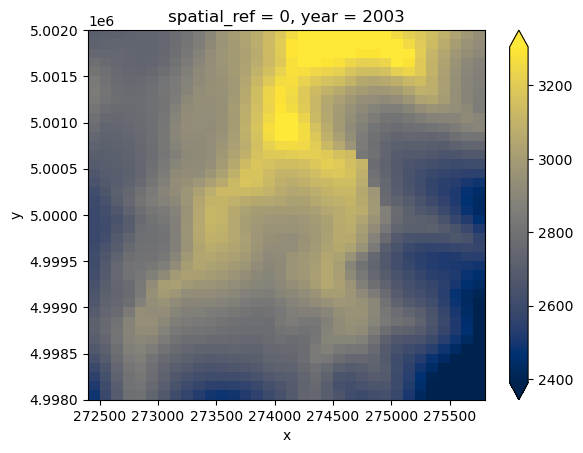

In [15]:
stacks["Sarenne"]["z"].sel(year=2003).plot(robust=True, cmap="cividis")